In [4]:
library(SingleCellExperiment)
library(ggplot2)

In [2]:
mydir = "/hps/nobackup/stegle/users/acuomo/all_scripts/sc_neuroseq/in_vivo_comparison/"

In [3]:
neuroseq_filename = paste0(mydir,"neuroseq_all_25pct_sce.Rds")
neuroseq = readRDS(neuroseq_filename)

In [5]:
neuroseq

class: SingleCellExperiment 
dim: 32738 205416 
metadata(0):
assays(1): counts
rownames(32738): MIR1302-10 FAM138A ... AC002321.2 AC002321.1
rowData names(0):
colnames(205416): TTCCCAGGTTCCATGA-1-0 AACCGCGAGGTCATCT-1-0 ...
  GCGCAGTAGGAATGGA-1-150 GTCCTCATCTAACTTC-1-150
colData names(23): index batch ... umap1 umap2
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [6]:
neuroseq <- scater::logNormCounts(neuroseq, log=T)
design <- model.matrix(~pool_id, data = colData(neuroseq))
alt.fit <- scran::trendVar(neuroseq, design = design, use.spikes = FALSE)
alt.decomp <- scran::decomposeVar(neuroseq, alt.fit)

Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'testVar' is deprecated.
See help("Deprecated")”

In [7]:
# genes_neuroseq = rownames(neuroseq)
genes_neuroseq = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),][1:2000,])

In [8]:
SN_filename = paste0(mydir,"snigra_sce.RDS")
SN = readRDS(SN_filename)

In [9]:
### select genes

In [10]:
### get top 500 HVGs from SN dataset and then intersect

In [11]:
SN <- scater::logNormCounts(SN, log=T)
design <- model.matrix(~dataset, data = colData(SN))
alt.fit2 <- scran::trendVar(SN, design = design, use.spikes = FALSE)
alt.decomp2 <- scran::decomposeVar(SN, alt.fit2)

Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'testVar' is deprecated.
See help("Deprecated")”

In [12]:
# genes_SN = rownames(SN)
genes_SN = rownames(alt.decomp2[order(alt.decomp2$bio, decreasing = TRUE),][1:2000,])

In [13]:
all_genes = unique(c(genes_SN,genes_neuroseq))

In [14]:
length(all_genes)

[1] 3565

In [15]:
genes_n = rownames(neuroseq)[rownames(neuroseq) %in% all_genes]
common_genes = rownames(SN)[rownames(SN) %in% genes_n]

In [16]:
length(common_genes)

[1] 3419

In [17]:
query = neuroseq[common_genes,]
reference = SN[common_genes,]

In [18]:
query

class: SingleCellExperiment 
dim: 3419 205416 
metadata(0):
assays(2): counts logcounts
rownames(3419): A2M AAK1 ... ZSWIM5 ZWINT
rowData names(0):
colnames(205416): TTCCCAGGTTCCATGA-1-0 AACCGCGAGGTCATCT-1-0 ...
  GCGCAGTAGGAATGGA-1-150 GTCCTCATCTAACTTC-1-150
colData names(23): index batch ... umap1 umap2
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [19]:
reference

class: SingleCellExperiment 
dim: 3419 40453 
metadata(0):
assays(2): counts logcounts
rownames(3419): A2M AAK1 ... ZSWIM5 ZWINT
rowData names(0):
colnames(40453): Miami6060a_GATCGATCATACGCTA-1
  Miami6060a_GTTCATTCATATACGC-1 ... MD5862c_CCATGTCGTTCGGCAC-1
  MD5862c_CACACAACATACGCCG-1
colData names(6): nUMI nGene ... tsne1 tsne2
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [20]:
names(colData(query))
names(colData(reference))

[1] "index"                       "batch"                      
 [3] "donor_id"                    "log1p_n_genes_by_counts"    
 [5] "log1p_total_counts"          "log1p_total_counts_mito"    
 [7] "n_genes_by_counts"           "pct_counts_in_top_100_genes"
 [9] "pct_counts_in_top_200_genes" "pct_counts_in_top_500_genes"
[11] "pct_counts_in_top_50_genes"  "pct_counts_mito"            
[13] "sample_id"                   "total_counts"               
[15] "total_counts_mito"           "cluster_id"                 
[17] "time_point"                  "pool_id"                    
[19] "treatment"                   "n_counts_all"               
[21] "celltype"                    "umap1"                      
[23] "umap2"

[1] "nUMI"     "nGene"    "dataset"  "clusters" "tsne1"    "tsne2"

In [21]:
query$batch_factor = "query"
reference$batch_factor = "reference"

In [22]:
## function from Shila

In [23]:
getJointPCA = function(reference, query, 
                       assayNameRef = "logcounts",
                       assayNameQuery = "logcounts") {
# reference and query are SingleCellExperiment objects
  all_assay = cbind(assay(query, assayNameQuery),
                    assay(reference, assayNameRef))
# batch factors can be dataset specific batches or just a factor labelling i.e. "query", "reference" 
#   batchFactor = factor(c(as.character(query$sample_id),
#                            as.character(reference$dataset)))
 batchFactor = factor(c(as.character(query$batch_factor),
                           as.character(reference$batch_factor)))
#   print(table(batchFactor))
  mbpca = batchelor::multiBatchPCA(all_assay,
                        batch = batchFactor,
                        d = 100
                        # BPPARAM = BiocParallel::MulticoreParam(workers = 4)
  )
  print("done multibatch PCA")
  dim(mbpca[[1]])
  out = do.call(batchelor::reducedMNN, mbpca)
  print("done batch correction")
  joint_mnn_pca = out$corrected
  return(joint_mnn_pca)
}

In [24]:
joint_mnn_pca = getJointPCA(reference, query)

Warning message in sweep(centered, 2, w, "/", check.margin = FALSE):
“'check.margin' is ignored when 'x' is a DelayedArray object or
  derivative”

[1] "done multibatch PCA"
[1] "done batch correction"


In [25]:
df_pca = as.data.frame(joint_mnn_pca[,c(1:2)])
colnames(df_pca) = paste0("PC",1:2)
head(df_pca)

,PC1,PC2
TTCCCAGGTTCCATGA-1-0,25.34177,20.17752
AACCGCGAGGTCATCT-1-0,25.10775,18.29556
TCACAAGTCTTATCTG-1-0,25.63981,19.69561
TACCTTACACGGTTTA-1-0,23.00347,19.21753
CCTAGCTAGCGCCTTG-1-0,25.45976,18.40290
CAAGATCAGGCTCTTA-1-0,26.27254,17.71102


In [26]:
df_pca$celltype = "FPP"
for (celltype in unique(query$celltype)){
    if (celltype != "FPP"){
        df_pca[rownames(df_pca) %in% colnames(query[,query$celltype == celltype]),]$celltype = celltype
    }
}

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning messa

In [27]:
df_pca[rownames(df_pca) %in% colnames(query[,query$celltype == 'Astro' & query$time_point=='D30']),]$celltype = "FPP"

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”

In [28]:
unique(df_pca$celltype)
head(df_pca,2)

[1] "FPP"     "P_FPP"   "NB"      "Sert"    "DA"      "CHem"    "unknown"
 [8] "Epen1"   "Astro"   "P_Sert"  "Epen2"

,PC1,PC2,celltype
TTCCCAGGTTCCATGA-1-0,25.34177,20.17752,FPP
AACCGCGAGGTCATCT-1-0,25.10775,18.29556,P_FPP


In [29]:
for (celltype in unique(reference$clusters)){
#     print(celltype)
    df_pca[rownames(df_pca) %in% colnames(reference[,reference$clusters == celltype]),]$celltype = celltype
}

In [30]:
reference$clusters = as.character(reference$clusters)
unique(reference$clusters)
tail(df_pca,2)

[1] "MG"        "MGfos"     "MGmp"      "ENDOstalk" "ENDOmural" "OLIGO5"   
 [7] "OLIGO3"    "OLIGO2"    "OLIGO1"    "OPC1"      "OPC2"      "OLIGO4"   
[13] "ASTROgfap" "ASTRO"     "ASTROfos"  "NEUROinh4" "NEUROinh2" "NEUROinh3"
[19] "NEUROdop"  "NEUROinh5" "NEUROinh1" "NEUROex1"  "ENDOfibro"

,PC1,PC2,celltype
MD5862c_CCATGTCGTTCGGCAC-1,-8.77379,-9.023774,NEUROinh1
MD5862c_CACACAACATACGCCG-1,-10.10538,-6.370929,NEUROinh2


In [31]:
df_pca$time_point = "-"
for (day in unique(query$time_point)){
    df_pca[rownames(df_pca) %in% colnames(query[,query$time_point == day]),]$time_point = day
}
head(df_pca,2)

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”

,PC1,PC2,celltype,time_point
TTCCCAGGTTCCATGA-1-0,25.34177,20.17752,FPP,D11
AACCGCGAGGTCATCT-1-0,25.10775,18.29556,P_FPP,D11


In [32]:
df_pca$treatment = "-"
for (treatment in unique(query$treatment)){
    df_pca[rownames(df_pca) %in% colnames(query[,query$treatment == treatment]),]$treatment = treatment
}
head(df_pca,2)

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”

,PC1,PC2,celltype,time_point,treatment
TTCCCAGGTTCCATGA-1-0,25.34177,20.17752,FPP,D11,NONE
AACCGCGAGGTCATCT-1-0,25.10775,18.29556,P_FPP,D11,NONE


In [33]:
df_pca$dataset = "neuroseq"
df_pca[rownames(df_pca) %in% colnames(reference),]$dataset = "SN"

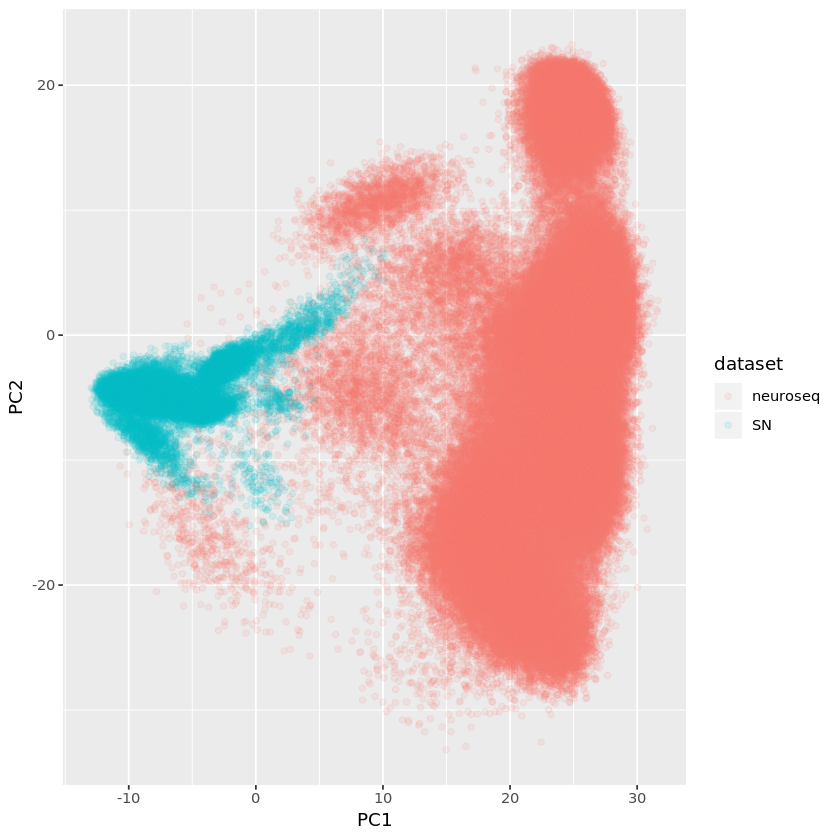

In [34]:
ggplot(df_pca, aes(x = PC1, y = PC2, colour = dataset)) + geom_point(alpha = 0.1)

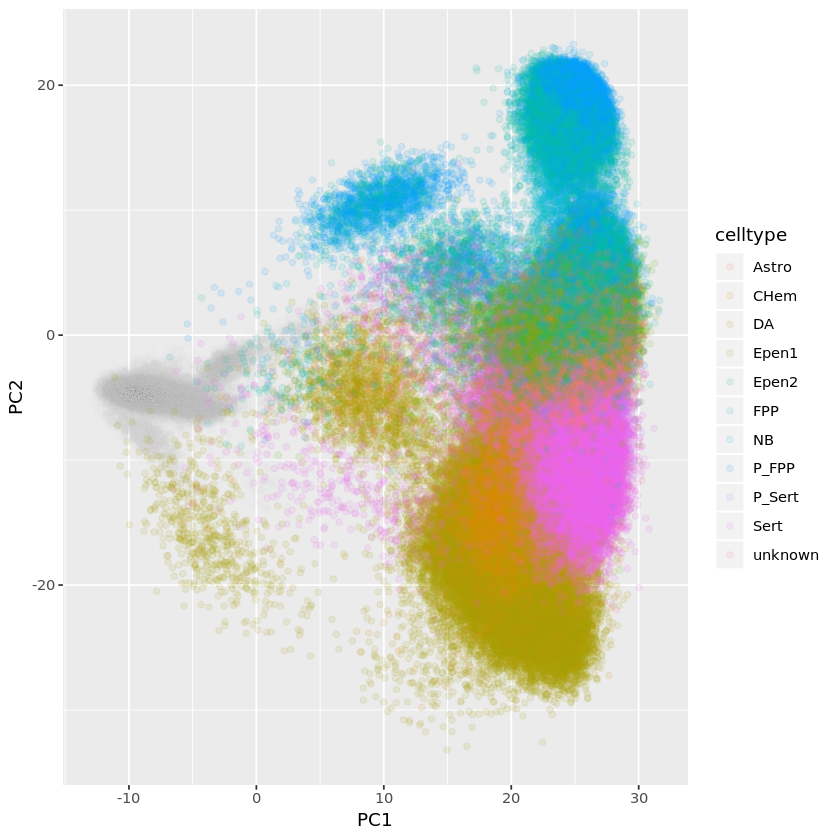

In [35]:
ggplot(df_pca, aes(x = PC1, y = PC2)) + geom_point(alpha = 0.01, col = "grey") +
    geom_point(aes(x = PC1, y = PC2, colour = celltype), data = df_pca[df_pca$dataset == "neuroseq",], alpha = 0.1) 

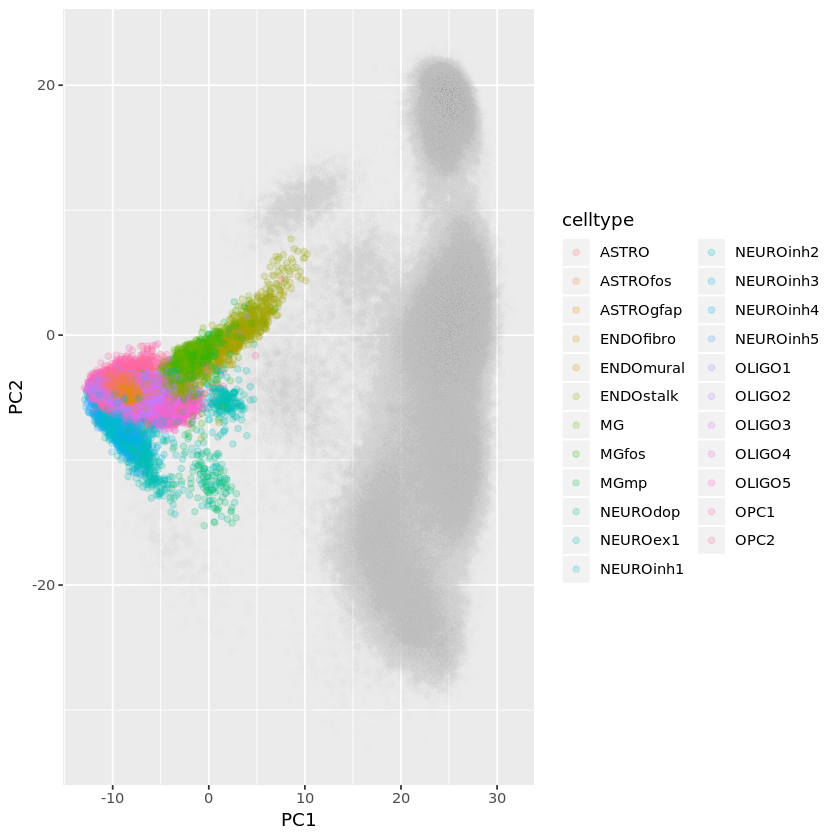

In [36]:
ggplot(df_pca, aes(x = PC1, y = PC2)) + geom_point(alpha = 0.01, col = "grey") +
    geom_point(aes(x = PC1, y = PC2, colour = celltype), data = df_pca[df_pca$dataset == "SN",], alpha = 0.2) 

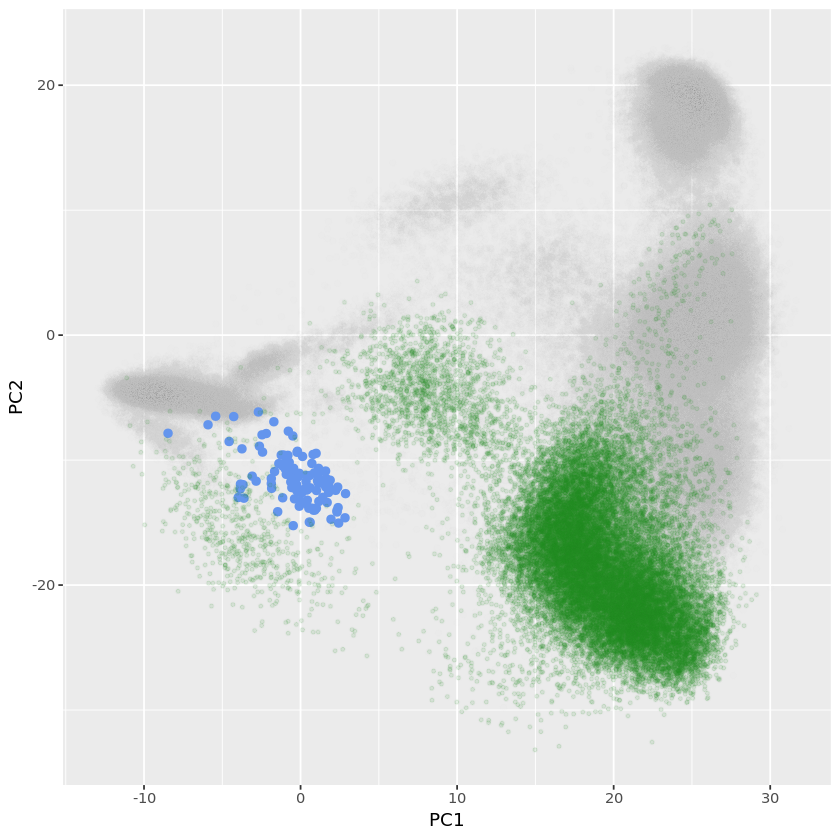

In [37]:
ggplot(df_pca, aes(x = PC1, y = PC2)) + geom_point(alpha = 0.01, col = "grey") +
    geom_point(aes(x = PC1, y = PC2), data = df_pca[df_pca$celltype == "NEUROdop",], col = "cornflowerblue", size=2) +
    geom_point(aes(x = PC1, y = PC2), data = df_pca[df_pca$celltype == "DA",], col = "forestgreen", alpha = 0.1, size = 0.8)

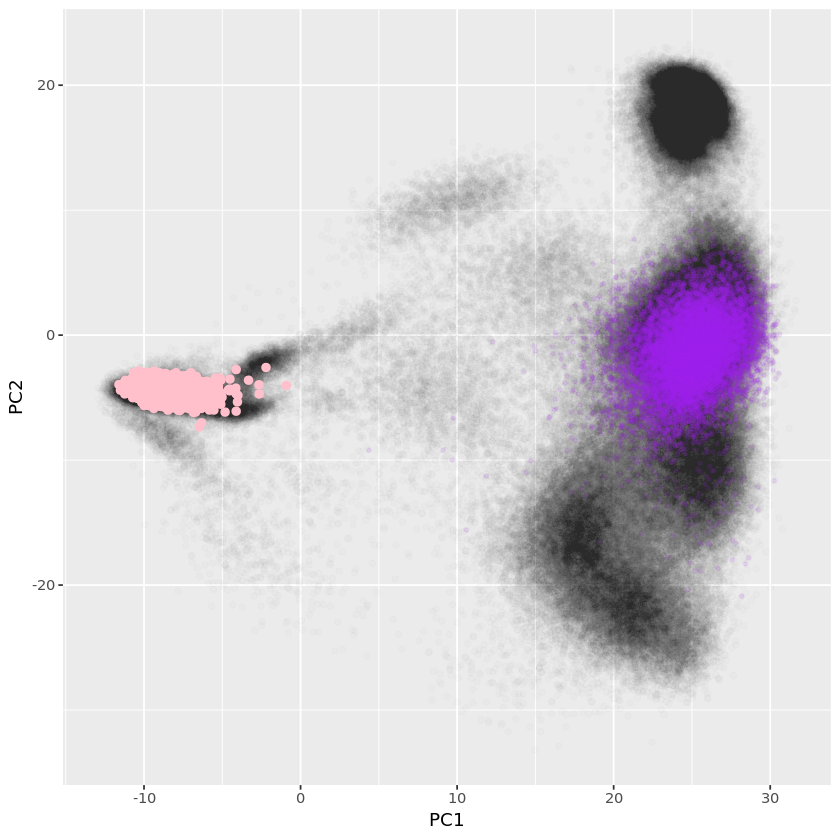

In [38]:
ggplot(df_pca, aes(x = PC1, y = PC2)) + geom_point(alpha = 0.01) +
    geom_point(aes(x = PC1, y = PC2), data = df_pca[grep("ASTRO",df_pca$celltype),], col = "pink", size=2) +
    geom_point(aes(x = PC1, y = PC2), data = df_pca[df_pca$celltype == "Astro",], col = "purple", alpha = 0.1, size = 0.8)

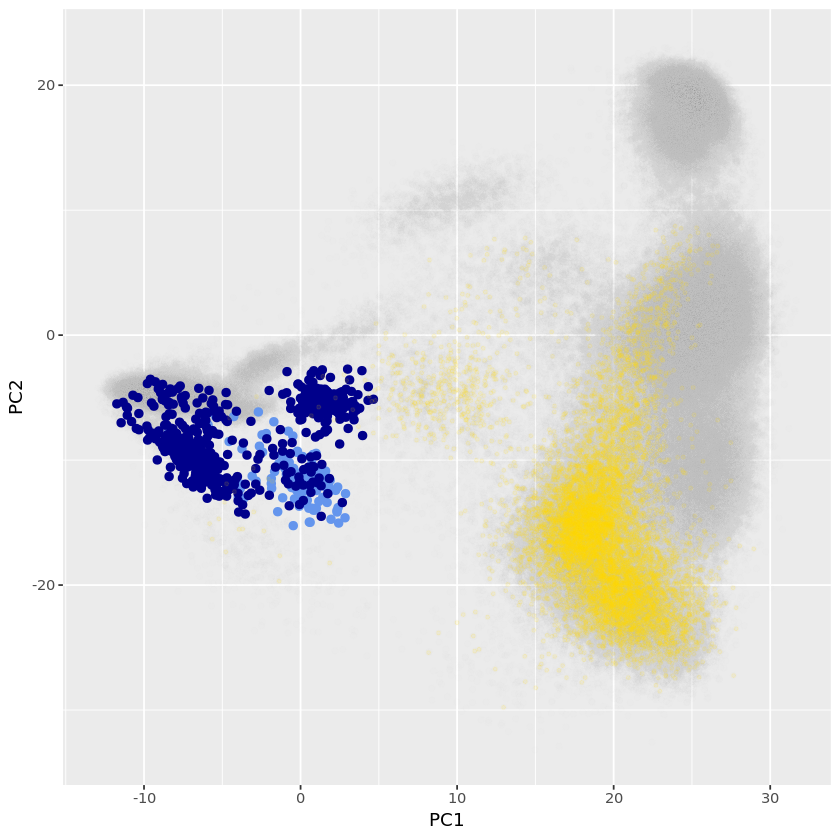

In [39]:
ggplot(df_pca, aes(x = PC1, y = PC2)) + geom_point(alpha = 0.01, col = "grey") +
    geom_point(aes(x = PC1, y = PC2), data = df_pca[df_pca$celltype == "NEUROdop",], col = "cornflowerblue", size=2) +
    geom_point(aes(x = PC1, y = PC2), data = df_pca[df_pca$celltype == "NEUROinh1",], col = "darkblue", size=2) +
    geom_point(aes(x = PC1, y = PC2), data = df_pca[df_pca$celltype == "CHem",], col = "gold", alpha = 0.1, size = 0.8)

In [76]:
sel_cells = colnames(neuroseq[,neuroseq$celltype == 'DA'])
# sel_cells = colnames(neuroseq[,neuroseq$time_point == 'D30' & neuroseq$celltype == 'DA'])
# sel_cells = colnames(neuroseq[,neuroseq$time_point == 'D52' & neuroseq$celltype == 'DA' & neuroseq$treatment == 'NONE'])
# sel_cells = colnames(neuroseq[,neuroseq$time_point == 'D52' & neuroseq$celltype == 'DA' & neuroseq$treatment == 'ROT'])
length(sel_cells)

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”

[1] 29801

In [77]:
closest_atlas_cell_ind = BiocNeighbors::queryKNN(
    joint_mnn_pca[colnames(SN),],
    joint_mnn_pca[sel_cells,],
  k = 1, get.index = TRUE, get.distance = FALSE)

In [79]:
mapped_cells = colnames(SN)[closest_atlas_cell_ind$index]

In [80]:
df = as.data.frame(colData(SN))

In [94]:
df_mapped = df[mapped_cells,]
# unique(df_mapped$clusters)
head(df_mapped)
nrow(df_mapped)
nrow(df_mapped[df_mapped$clusters == "NEUROdop",])/nrow(df_mapped)
nrow(df_mapped[df_mapped$clusters == "NEUROinh1",])/nrow(df_mapped)
nrow(df_mapped[df_mapped$clusters == "ENDOmural",])/nrow(df_mapped)

,nUMI,nGene,dataset,clusters,tsne1,tsne2
Miami6063c_TGGACGCGTAAATGTG-1,7081,3095,Miami6063,NEUROdop,3.5659955,5.645418
Miami6063a_ATCACGATCATCGATG-1,7455,3882,Miami6063,NEUROinh1,0.7428302,3.712799
Miami6063c_TGGACGCGTAAATGTG-1.1,7081,3095,Miami6063,NEUROdop,3.5659955,5.645418
Miami6063c_TGGACGCGTAAATGTG-1.2,7081,3095,Miami6063,NEUROdop,3.5659955,5.645418
Miami6063c_TGGACGCGTAAATGTG-1.3,7081,3095,Miami6063,NEUROdop,3.5659955,5.645418
Miami6063c_TGGACGCGTAAATGTG-1.4,7081,3095,Miami6063,NEUROdop,3.5659955,5.645418


[1] 29801

[1] 0.7858797

[1] 0.1292239

[1] 0.03627395

In [60]:
head(df,2)

,nUMI,nGene,dataset,clusters,tsne1,tsne2
Miami6060a_GATCGATCATACGCTA-1,3130,1729,Miami6060,MG,4.293051,-9.855962
Miami6060a_GTTCATTCATATACGC-1,2981,1687,Miami6060,MGfos,5.395852,-8.471175


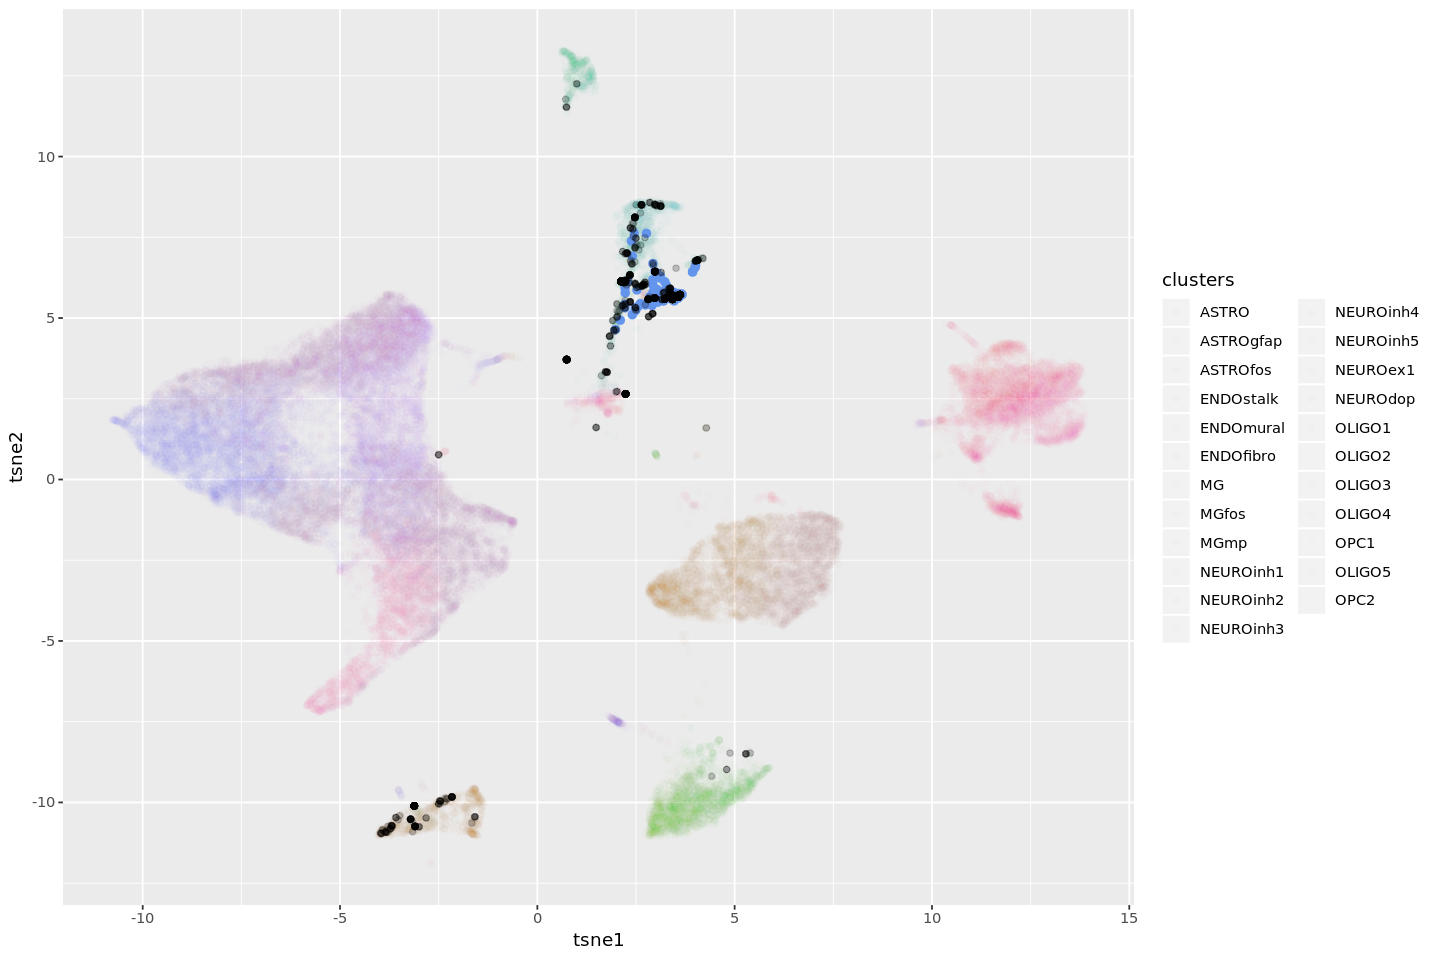

In [61]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot(df, aes(x = tsne1, y = tsne2, colour = clusters)) + geom_point(alpha = 0.01) +
    geom_point(aes(x = tsne1, y = tsne2), data = df[df$clusters == "NEUROdop",], col = "cornflowerblue", size=2) +
#     geom_point(aes(x = tsne1, y = tsne2), data = df[df$clusters == "OLIGO5",], col = "coral", alpha = 0.1) +
    geom_point(aes(x = tsne1, y = tsne2), data = df[mapped_cells,], col = "black", alpha = 0.2)

In [62]:
sn_clusters = as.character(unique(SN$clusters))
sn_clusters

[1] "MG"        "MGfos"     "MGmp"      "ENDOstalk" "ENDOmural" "OLIGO5"   
 [7] "OLIGO3"    "OLIGO2"    "OLIGO1"    "OPC1"      "OPC2"      "OLIGO4"   
[13] "ASTROgfap" "ASTRO"     "ASTROfos"  "NEUROinh4" "NEUROinh2" "NEUROinh3"
[19] "NEUROdop"  "NEUROinh5" "NEUROinh1" "NEUROex1"  "ENDOfibro"

In [63]:
# length(mapped_cells)
for (cluster in sn_clusters){
    n = length(mapped_cells[mapped_cells %in% rownames(df[df$clusters == cluster,])])
    if (n/length(mapped_cells) > 0.05){
        print(c(cluster, n, n/length(mapped_cells)))
    }
}

[1] "NEUROdop"         "8819"             "0.83576573161486"
[1] "NEUROinh1"         "1444"              "0.136846095526914"


In [64]:
closest_atlas_cell_ind = BiocNeighbors::queryKNN(
    joint_mnn_pca[colnames(SN[,grep("NEURO",SN$clusters)]),],
    joint_mnn_pca[sel_cells,],
  k = 2, get.index = TRUE, get.distance = FALSE)

In [65]:
mapped_cells = colnames(SN[,grep("NEURO",SN$clusters)])[closest_atlas_cell_ind$index]

In [66]:
nrow(df)
nrow(df[grep("NEURO",df$clusters),])
nrow(df[grep("OLIGO",df$clusters),])
nrow(df[df$clusters == "NEUROdop",])
nrow(df[df$clusters == "NEUROinh1",])

[1] 40453

[1] 2028

[1] 23834

[1] 110

[1] 577

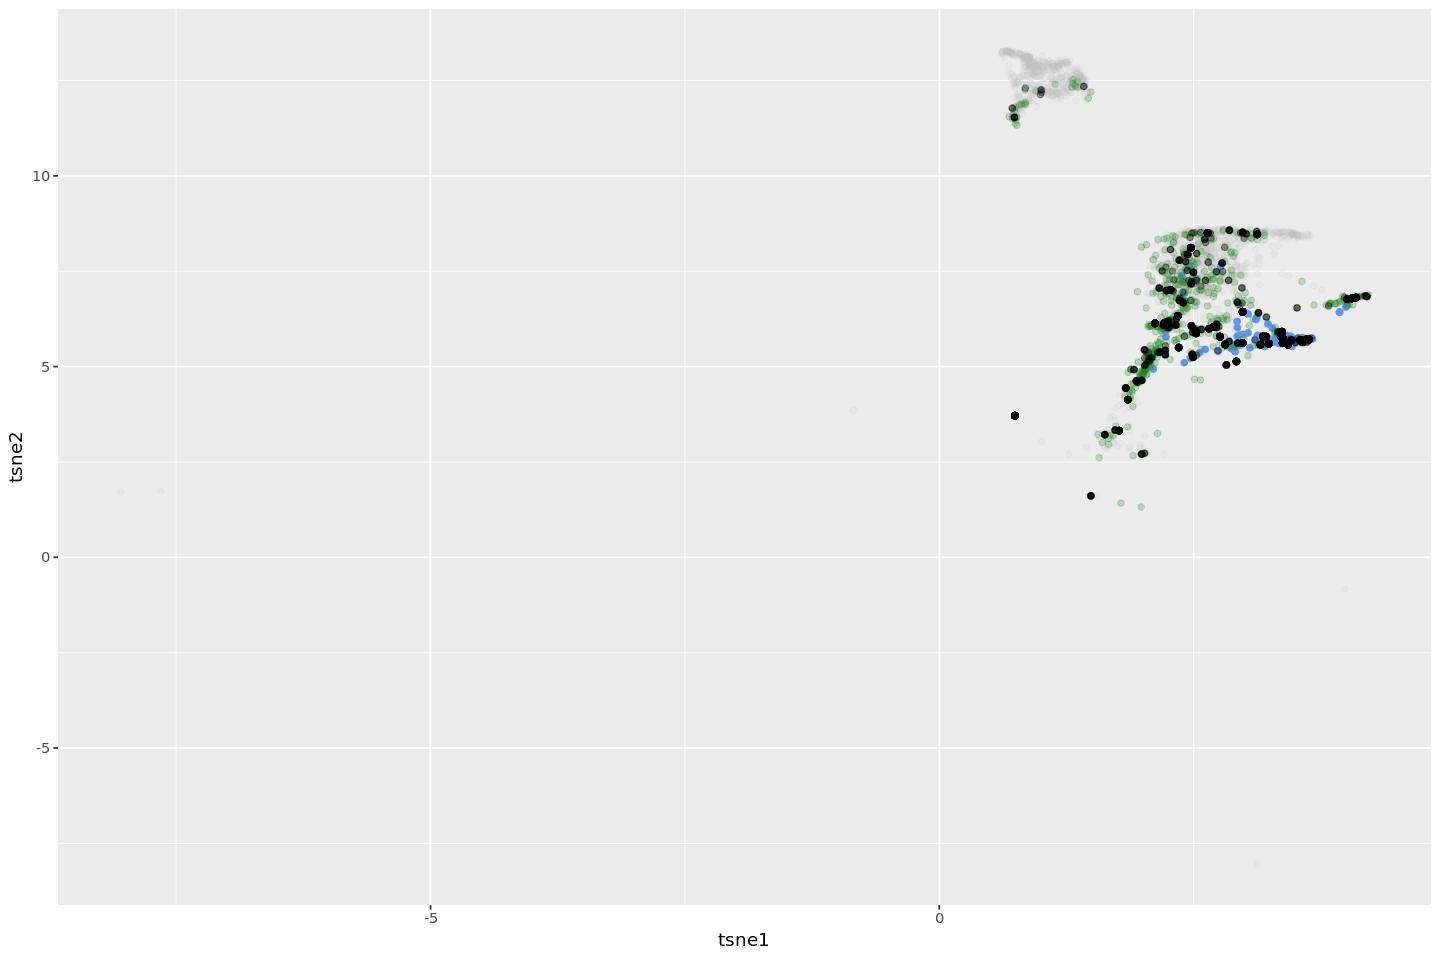

In [67]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot(df[grep("NEURO",df$clusters),], aes(x = tsne1, y = tsne2)) + geom_point(alpha = 0.1, col = "grey") +
    geom_point(aes(x = tsne1, y = tsne2), data = df[df$clusters == "NEUROdop",], col = "cornflowerblue") +
    geom_point(aes(x = tsne1, y = tsne2), data = df[df$clusters == "NEUROinh1",], col = "forestgreen", alpha = 0.2) +
    geom_point(aes(x = tsne1, y = tsne2), data = df[mapped_cells,], col = "black", alpha = 0.3)

In [68]:
sn_clusters = as.character(unique(SN$clusters))
sn_clusters

[1] "MG"        "MGfos"     "MGmp"      "ENDOstalk" "ENDOmural" "OLIGO5"   
 [7] "OLIGO3"    "OLIGO2"    "OLIGO1"    "OPC1"      "OPC2"      "OLIGO4"   
[13] "ASTROgfap" "ASTRO"     "ASTROfos"  "NEUROinh4" "NEUROinh2" "NEUROinh3"
[19] "NEUROdop"  "NEUROinh5" "NEUROinh1" "NEUROex1"  "ENDOfibro"

In [69]:
# length(mapped_cells)
for (cluster in sn_clusters){
    n = length(mapped_cells[mapped_cells %in% rownames(df[df$clusters == cluster,])])
    if (n/length(mapped_cells) > 0.01){
        print(c(cluster, n, n/length(mapped_cells)))
    }
}

[1] "NEUROdop"          "17256"             "0.817664897649735"
[1] "NEUROinh1"         "3817"              "0.180866186504928"


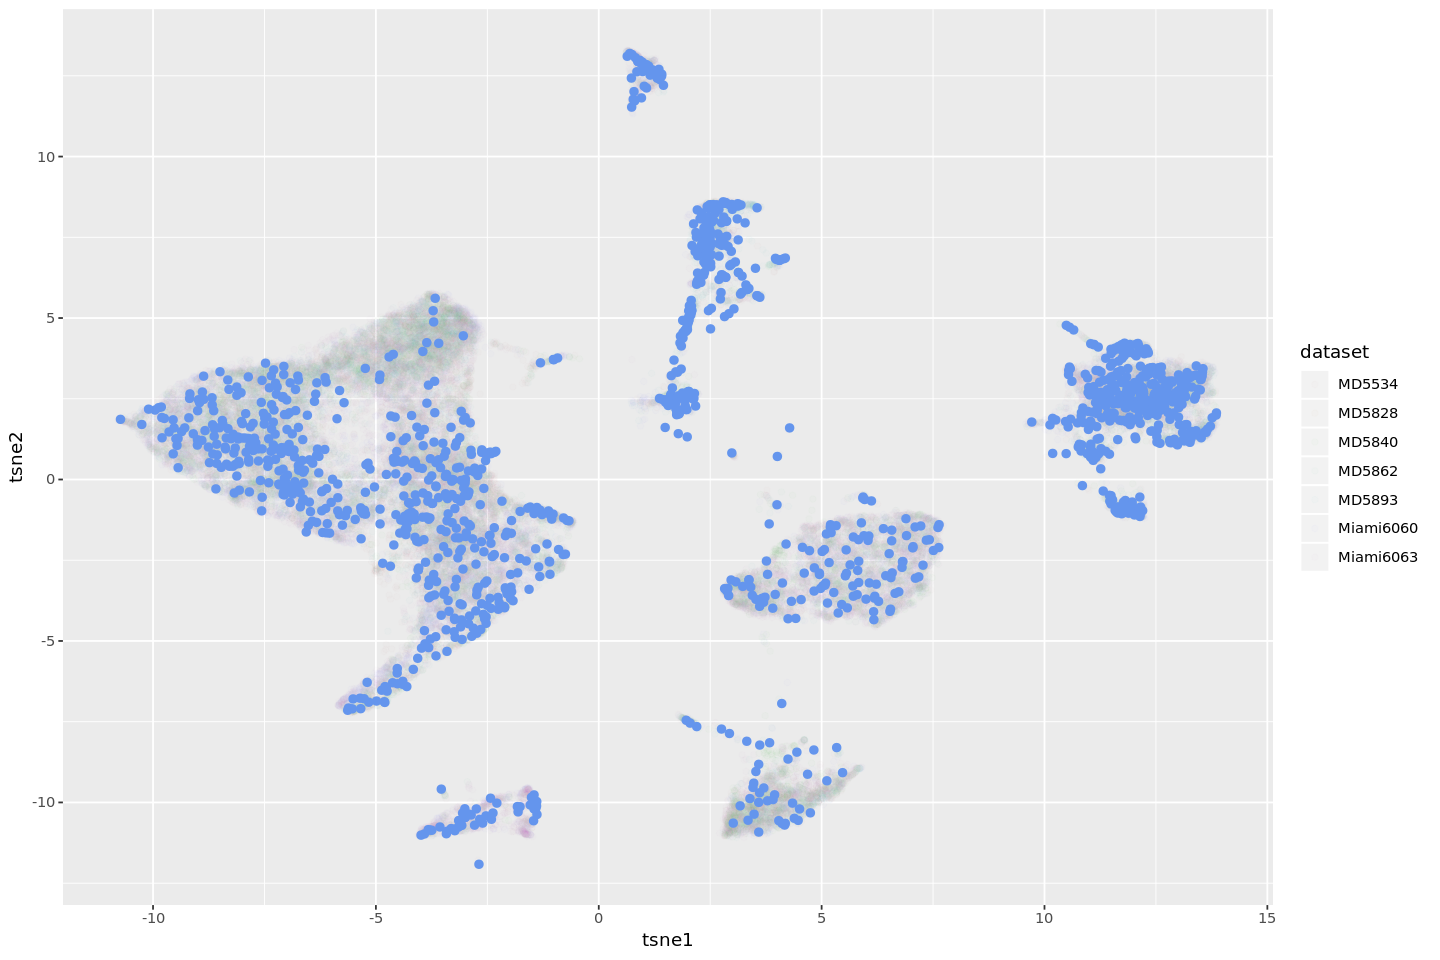

In [79]:
# donor 5828 had trauma, check if that means more astrocytes?
options(repr.plot.width=12, repr.plot.height=8)
ggplot(df, aes(x = tsne1, y = tsne2, colour = dataset)) + geom_point(alpha = 0.01) +
    geom_point(aes(x = tsne1, y = tsne2), data = df[df$dataset == "MD5828",], col = "cornflowerblue", size=2)

In [72]:
query$celltype[query$celltype == 'Astro' & neuroseq$time_point == 'D30'] <- "FPP"

In [94]:
mat = matrix(0, nrow = length(unique(query$celltype)), ncol = length(unique(reference$clusters)))
nrow(mat)
ncol(mat)

[1] 11

[1] 23

In [95]:
rownames(mat) = unique(query$celltype)
colnames(mat) = unique(reference$clusters)
# mat

In [98]:
i = 0
for (celltype in unique(query$celltype)){
    j = 0
    i = i+1
    sel_cells = colnames(query[,query$celltype == celltype])
    closest_atlas_cell_ind = BiocNeighbors::queryKNN(
        joint_mnn_pca[colnames(reference),],
        joint_mnn_pca[sel_cells,],
        k = 2, get.index = TRUE, get.distance = FALSE)
    mapped_cells = colnames(reference)[closest_atlas_cell_ind$index]
    for (cluster in unique(reference$clusters)){
        j = j+1
        n = length(mapped_cells[mapped_cells %in% colnames(reference[,reference$clusters == cluster])])
        mat[i,j] = n/length(mapped_cells)
    }
}

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning messa

In [99]:
mat

,MG,MGfos,MGmp,ENDOstalk,ENDOmural,OLIGO5,OLIGO3,OLIGO2,OLIGO1,OPC1,...,ASTRO,ASTROfos,NEUROinh4,NEUROinh2,NEUROinh3,NEUROdop,NEUROinh5,NEUROinh1,NEUROex1,ENDOfibro
FPP,0.000000e+00,4.824951e-04,1.901031e-03,0.286872274,0.157592543,0.000000e+00,0.0000000000,9.649902e-06,0.000000e+00,9.649902e-05,...,0.000000e+00,9.649902e-05,2.412475e-04,0.0045740533,5.886440e-04,0.006552283,0.0037055622,0.044071100,2.344926e-03,0.475865596
P_FPP,0.000000e+00,3.302074e-05,1.651037e-05,0.359166557,0.324527803,0.000000e+00,0.0000000000,0.000000e+00,1.651037e-05,2.146348e-04,...,0.000000e+00,0.000000e+00,3.962488e-04,0.0170552107,6.439044e-04,0.001584995,0.0077433628,0.001915203,2.955356e-03,0.193336415
NB,0.000000e+00,0.000000e+00,0.000000e+00,0.479146222,0.076300294,0.000000e+00,0.0000000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,4.906771e-03,0.0088321884,7.360157e-04,0.011040236,0.0208537782,0.020117763,4.416094e-03,0.373405299
Sert,3.677868e-03,4.207155e-02,1.085717e-03,0.043686553,0.127897508,1.357147e-05,0.0075185929,9.500027e-05,1.221432e-04,3.935726e-04,...,0.000000e+00,7.125020e-03,8.142880e-05,0.0016150046,8.142880e-05,0.093154552,0.0007871451,0.311410890,2.578579e-04,0.196446990
DA,8.388980e-05,1.224791e-03,5.033388e-05,0.002080467,0.002801919,3.187812e-04,0.0000000000,5.033388e-05,1.677796e-05,1.677796e-05,...,0.000000e+00,0.000000e+00,3.858931e-04,0.0056877286,3.322036e-03,0.858192678,0.0014932385,0.118670514,5.033388e-05,0.004412604
CHem,0.000000e+00,3.790751e-04,8.055345e-04,0.004880591,0.008292267,1.895375e-04,0.0000000000,0.000000e+00,0.000000e+00,4.738438e-05,...,0.000000e+00,0.000000e+00,1.895375e-04,0.0002843063,3.790751e-04,0.813115997,0.0005212282,0.159401061,4.738438e-05,0.006159970
unknown,0.000000e+00,8.587258e-03,0.000000e+00,0.037119114,0.055124654,0.000000e+00,0.0002770083,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.770083e-04,0.000000e+00,0.0005540166,5.540166e-04,0.543490305,0.0000000000,0.115235457,5.540166e-04,0.232409972
Epen1,2.082379e-05,1.811670e-03,6.684436e-03,0.018408230,0.281475157,0.000000e+00,0.0001457665,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.665903e-04,2.082379e-05,0.0003748282,6.247137e-05,0.008683520,0.0004581234,0.240223231,6.247137e-05,0.373557953
Astro,0.000000e+00,3.225050e-04,1.817755e-03,0.011756773,0.136273015,0.000000e+00,0.0000000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.931863e-05,4.808256e-03,0.000000e+00,0.0000000000,0.000000e+00,0.036736250,0.0000000000,0.041544506,0.000000e+00,0.751817755
P_Sert,0.000000e+00,3.846154e-03,0.000000e+00,0.167307692,0.337500000,0.000000e+00,0.0000000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.923077e-03,0.000000e+00,0.0000000000,0.000000e+00,0.008653846,0.0000000000,0.123076923,0.000000e+00,0.161538462


In [108]:
# library(reshape2)
mat_melt = melt(mat)
head(mat_melt)

Var1,Var2,value
FPP,MG,0.0000000000
P_FPP,MG,0.0000000000
NB,MG,0.0000000000
Sert,MG,0.0036778677
DA,MG,0.0000838898
CHem,MG,0.0000000000


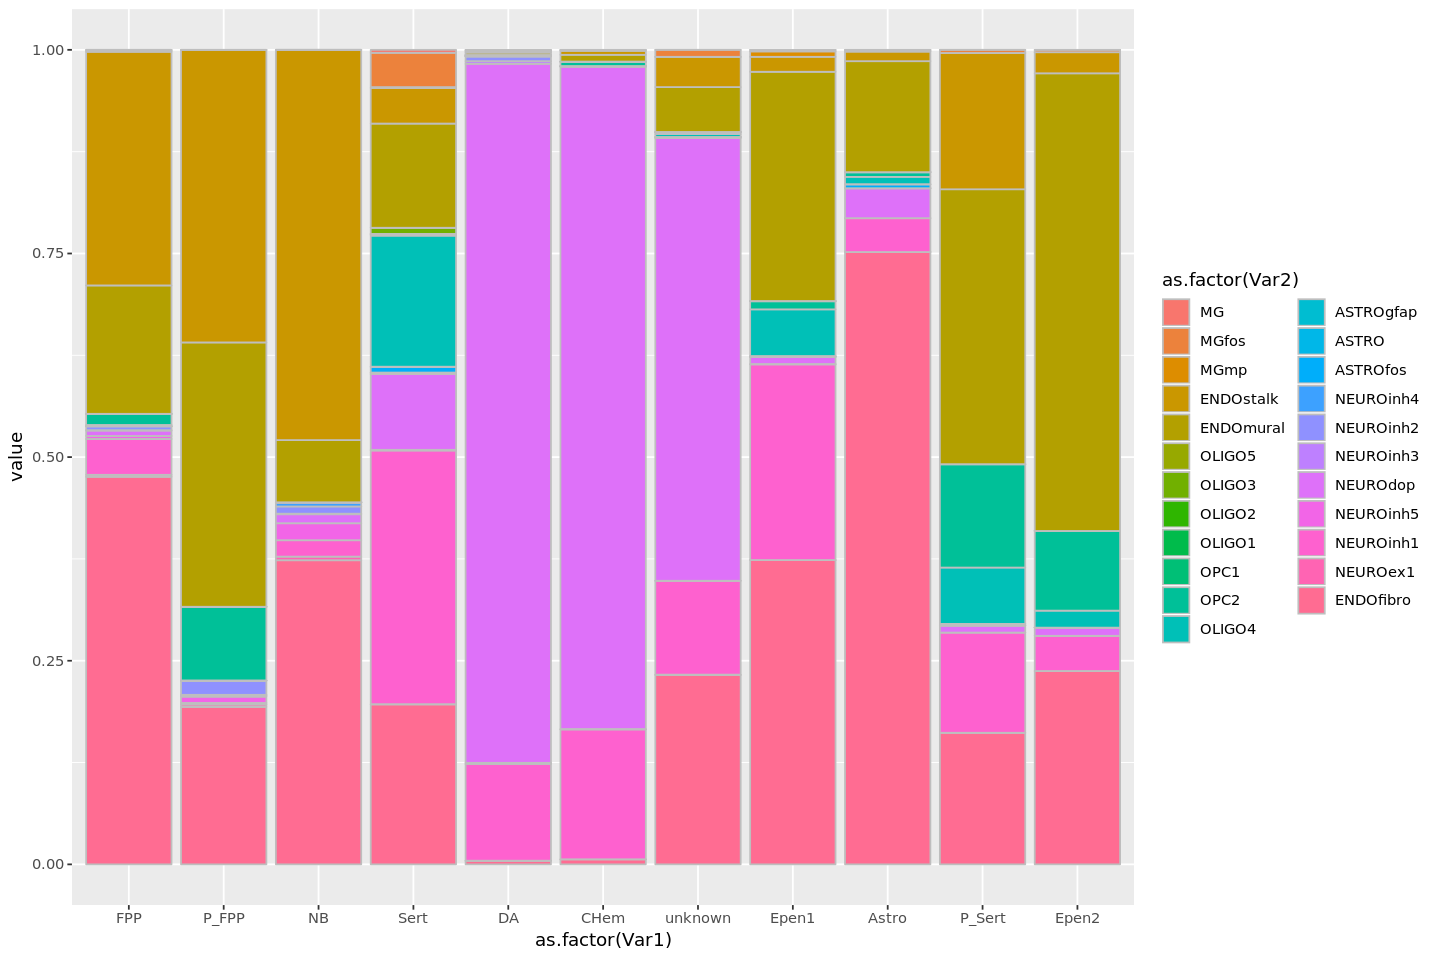

In [113]:
df = as.data.frame(mat_melt)
ggplot(df, aes(x = as.factor(Var1), y = value, fill = as.factor(Var2))) + geom_bar(stat="identity", col = "grey")

In [128]:
query2 = query[,query$celltype %in% c('DA','Sert','CHem')]
query2

class: SingleCellExperiment 
dim: 3456 77195 
metadata(0):
assays(2): counts logcounts
rownames(3456): AAK1 AANAT ... ZWINT ZZEF1
rowData names(0):
colnames(77195): TAGAGCTAGCGTAATA-1-6 CATGACAGTGTGCCTG-1-6 ...
  GCGCAGTAGGAATGGA-1-150 GTCCTCATCTAACTTC-1-150
colData names(24): index batch ... umap2 batch_factor
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [129]:
reference2 = reference[,grep("NEURO",reference$clusters)]
reference2

class: SingleCellExperiment 
dim: 3456 2028 
metadata(0):
assays(2): counts logcounts
rownames(3456): AAK1 AANAT ... ZWINT ZZEF1
rowData names(0):
colnames(2028): Miami6060a_CAGTCCTAGCGCTTAT-1
  Miami6060a_GCACTCTCATGTAAGA-1 ... MD5862c_CCATGTCGTTCGGCAC-1
  MD5862c_CACACAACATACGCCG-1
colData names(7): nUMI nGene ... tsne2 batch_factor
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [130]:
mat2 = matrix(0, nrow = length(unique(query2$celltype)), ncol = length(unique(reference2$clusters)))
nrow(mat2)
ncol(mat2)

[1] 3

[1] 7

In [131]:
rownames(mat2) = unique(query2$celltype)
colnames(mat2) = unique(reference2$clusters)

In [132]:
i = 0
for (celltype in unique(query2$celltype)){
    j = 0
    i = i+1
    sel_cells = colnames(query[,query2$celltype == celltype])
    closest_atlas_cell_ind = BiocNeighbors::queryKNN(
        joint_mnn_pca[colnames(reference2),],
        joint_mnn_pca[sel_cells,],
        k = 2, get.index = TRUE, get.distance = FALSE)
    mapped_cells = colnames(reference2)[closest_atlas_cell_ind$index]
    for (cluster in unique(reference2$clusters)){
        j = j+1
        n = length(mapped_cells[mapped_cells %in% colnames(reference2[,reference2$clusters == cluster])])
        mat2[i,j] = n/length(mapped_cells)
    }
}

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”

In [133]:
mat2

,NEUROinh4,NEUROinh2,NEUROinh3,NEUROdop,NEUROinh5,NEUROinh1,NEUROex1
Sert,0.0003695604,0.004971346,0.001209931,0.2368629,0.006181277,0.7487445,0.001660490
DA,0.0003426834,0.006423756,0.002105945,0.2051614,0.007433114,0.7766390,0.001894105
CHem,0.0002272641,0.004242264,0.001344646,0.1868869,0.006344457,0.7996477,0.001306769


In [134]:
mat2_melt = melt(mat2)
head(mat2_melt)

Var1,Var2,value
Sert,NEUROinh4,0.0003695604
DA,NEUROinh4,0.0003426834
CHem,NEUROinh4,0.0002272641
Sert,NEUROinh2,0.0049713464
DA,NEUROinh2,0.0064237561
CHem,NEUROinh2,0.0042422636


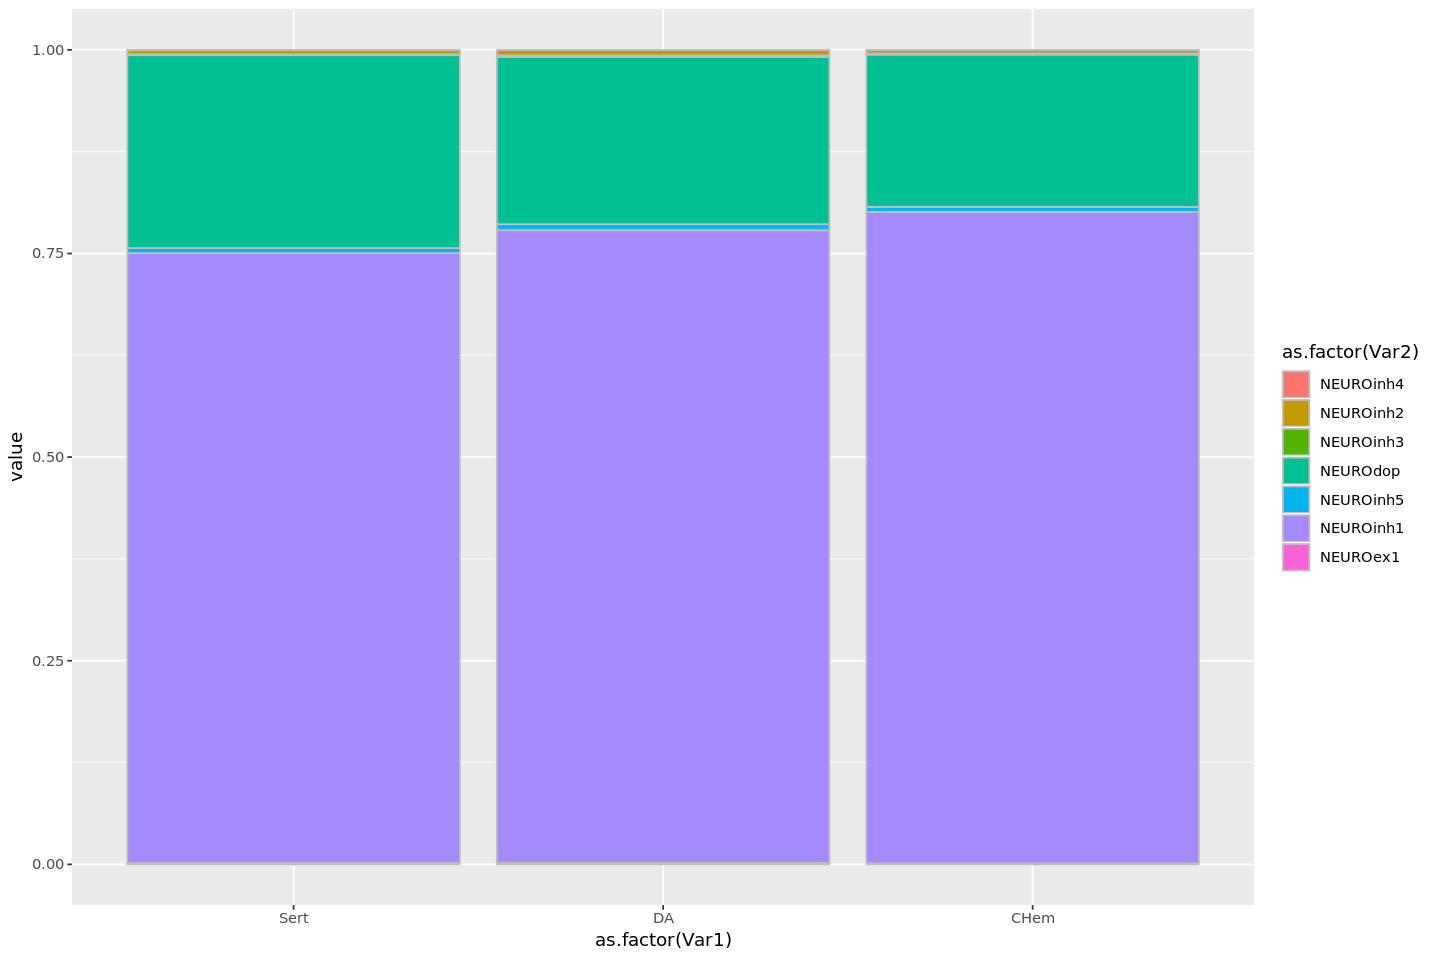

In [135]:
df = as.data.frame(mat2_melt)
ggplot(df, aes(x = as.factor(Var1), y = value, fill = as.factor(Var2))) + geom_bar(stat="identity", col = "grey")